# Preprocessing UT Aggregated Data
- Issue of provided ReportingUnitNativeID for ReportingUnitTypeCV = 'subarea' keeps getting read in as date datatype.
- Will temp solve by using custom wade id value

- read in shapefiles first, make custom id, then read in timeseries, assign custom id

In [31]:
#Needed Libararies

# working with data
import os
import numpy as np
import pandas as pd
import geopandas as gpd

# visulizaiton
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import geoplot as gplt # for plotting maps

# API retrieval
import requests
import json

# Cleanup
from datetime import datetime
pd.set_option('display.max_columns', 999)  # How to display all columns of a Pandas DataFrame in Jupyter Notebook

In [2]:
#Setting work directory, reading inputs, creating dataframe
workingDir = "G:/Shared drives/WaDE Data/Utah/AggregatedAmounts/RawInputData"
os.chdir(workingDir)

# Shapefile Data

In [3]:
# Shapefile input
UT_County_SF = gpd.read_file('UT_Counties_SF/UT_Counties.shp', crs="EPSG:4326")
UT_HUC8_SF = gpd.read_file('UT_HUC8_SF/UT_HUC8.shp', crs="EPSG:4326")
UT_Subarea_SF = gpd.read_file('UT_Subarea_SF/UT_Subarea.shp', crs="EPSG:4326")

#### County

In [4]:
columnsList = ['RU_Name', 'RU_ID', 'RU_Type','geometry']
dfCountyShape = pd.DataFrame(columns=columnsList)
dfCountyShape['RU_Name'] = UT_County_SF['NAME']
dfCountyShape['RU_ID'] = UT_County_SF['State_RU']
dfCountyShape['RU_ID'] = dfCountyShape['RU_ID'].map(lambda x: x.lstrip("46-"))
dfCountyShape['RU_ID'] = "4" + dfCountyShape['RU_ID']
dfCountyShape['RU_Type'] = 'County'
dfCountyShape['geometry'] = UT_County_SF['geometry']
dfCountyShape.head(3)

,RU_Name,RU_ID,RU_Type,geometry
0,Beaver,49001,County,"POLYGON ((-114.05048 38.49996, -114.05015 38.5..."
1,Box Elder,49003,County,"POLYGON ((-114.04255 41.21092, -114.04172 41.9..."
2,Duchesne,49013,County,"POLYGON ((-110.90435 40.70150, -110.89777 40.7..."


#### HUC8

In [5]:
columnsList = ['RU_Name', 'RU_ID', 'RU_Type','geometry']
dfHUC8Shape = pd.DataFrame(columns=columnsList)
dfHUC8Shape['RU_Name'] = UT_HUC8_SF['NAME']
dfHUC8Shape['RU_ID'] = UT_HUC8_SF['HUC8']
dfHUC8Shape['RU_Type'] = 'HUC8'
dfHUC8Shape['geometry'] = UT_HUC8_SF['geometry']
dfHUC8Shape.head(3)

,RU_Name,RU_ID,RU_Type,geometry
0,Meadow Valley Wash,15010013,HUC8,"POLYGON ((-114.03649 37.95701, -114.03647 37.9..."
1,Lower Virgin,15010010,HUC8,"POLYGON ((-114.06750 37.60696, -114.06708 37.6..."
2,Fort Pearce Wash,15010009,HUC8,"POLYGON ((-112.75584 37.06340, -112.75670 37.0..."


#### subarea

In [6]:
# create custom id
def assignCustomID(val):
    val = str(val)
    outstring = "WaDEUTagRU" + val
    return outstring

dftemp = pd.DataFrame(index=UT_Subarea_SF.index)
dftemp["Count"] = range(1, len(dftemp.index) + 1)
UT_Subarea_SF['custom_RU_ID'] = dftemp.apply(lambda row: assignCustomID(row['Count']), axis=1)
UT_Subarea_SF.head()

,RU_ID,RU_Name,StateNum,State_RU,Shape_Leng,State,Shape_Le_1,Shape_Area,LinkKey,geometry,custom_RU_ID
0,00-01-03,Curlew Valley,46,46-00-01-03,2.058765,UT,2.058765,0.115650,00-01-03Curlew Valley,"POLYGON ((-112.58699 42.00092, -112.57918 41.9...",WaDEUTagRU1
1,000-01-03,Clear Creek,46,46-000-01-03,0.707791,UT,0.707791,0.021416,000-01-03Clear Creek,"POLYGON ((-113.17778 42.00082, -113.20384 41.9...",WaDEUTagRU2
2,00-07-02,Promontory Point,46,46-00-07-02,2.543908,UT,2.543908,0.166048,00-07-02Promontory Point,"POLYGON ((-112.36394 42.00018, -112.38128 41.9...",WaDEUTagRU3
3,000-01-02,Yost,46,46-000-01-02,0.869172,UT,0.869172,0.030750,000-01-02Yost,"POLYGON ((-113.45058 41.99980, -113.47376 41.9...",WaDEUTagRU4
4,000-02-00,Goose Creek,46,46-000-02-00,0.800608,UT,0.800608,0.031581,000-02-00Goose Creek,"POLYGON ((-113.86094 41.99704, -113.81920 41.9...",WaDEUTagRU5


In [7]:
# UT, Subarea
# get name and geometry
###########################################################################
columnsList = ['RU_Name', 'RU_ID', 'RU_Type','geometry']
dfSubareaShape = pd.DataFrame(columns=columnsList)
dfSubareaShape['RU_Name'] = UT_Subarea_SF['RU_Name']
dfSubareaShape['RU_ID'] = UT_Subarea_SF['custom_RU_ID'] # use custom id here for subarea
dfSubareaShape['RU_Type'] = 'Subarea'
dfSubareaShape['geometry'] = UT_Subarea_SF['geometry']
dfSubareaShape.head(3)

,RU_Name,RU_ID,RU_Type,geometry
0,Curlew Valley,WaDEUTagRU1,Subarea,"POLYGON ((-112.58699 42.00092, -112.57918 41.9..."
1,Clear Creek,WaDEUTagRU2,Subarea,"POLYGON ((-113.17778 42.00082, -113.20384 41.9..."
2,Promontory Point,WaDEUTagRU3,Subarea,"POLYGON ((-112.36394 42.00018, -112.38128 41.9..."


In [8]:
# Concatenate shp datafraes together.
frames = [dfCountyShape, dfHUC8Shape, dfSubareaShape]
dfAllShape = pd.concat(frames).reset_index()
dfAllShape

,index,RU_Name,RU_ID,RU_Type,geometry
0,0,Beaver,49001,County,"POLYGON ((-114.05048 38.49996, -114.05015 38.5..."
1,1,Box Elder,49003,County,"POLYGON ((-114.04255 41.21092, -114.04172 41.9..."
2,2,Duchesne,49013,County,"POLYGON ((-110.90435 40.70150, -110.89777 40.7..."
3,3,Emery,49015,County,"POLYGON ((-111.30701 38.67233, -111.29914 38.6..."
4,4,Grand,49019,County,"POLYGON ((-110.17897 38.90920, -110.17447 38.9..."
...,...,...,...,...,...
240,144,Brigham City,WaDEUTagRU145,Subarea,"POLYGON ((-112.01361 41.64418, -112.00460 41.6..."
241,145,Cache Valley,WaDEUTagRU146,Subarea,"POLYGON ((-111.50799 42.00025, -111.50842 41.9..."
242,146,Randolph,WaDEUTagRU147,Subarea,"POLYGON ((-111.04977 41.80850, -111.05113 41.5..."
243,147,Evanston,WaDEUTagRU148,Subarea,"MULTIPOLYGON (((-110.72426 40.99222, -110.7332..."


# Water Budget Data

In [9]:
# check input 2011
fileInput = "Water_Budget_WaDE_Compatible_Table.xlsx"
df = pd.read_excel(fileInput)
print(len(df))
df.head(1)

13071


,ObjectId,ReportingUnitNativeID,ReportingUnitTypeCV,ReportYearCV,TimeframeStart,TimeframeEnd,BeneficialUseCategory,Amount,Geometry,InterbasinTransferFromID,InterbasinTransferToID,IrrigatedAcreage,MethodName,NAICSCodeCV,OrganizationID,PopulationServed,PowerGeneratedGWh,ReportingUnitName,USGSCategoryCV,VariableCV,VariableSpecificCV,WaterSourceID
0,1,49001,County,2005,2005-10-01,2006-09-30,Agriculture,80061.753287,<Null>,<Null>,<Null>,<Null>,Consumptive Use Estimate,111000,UTDWRE,<Null>,<Null>,Beaver,Irrigation,Consumptive Use,"Consumptive Use, Irrigation",Fresh_SW_GW


### solve bad ReportingUnitNativeID issue

In [11]:
# copy df
# Remove ReportingUnitTypeCV = Subarea type
df1 = df.copy()
df1 = df1[df1['ReportingUnitTypeCV'] != 'Subarea'].reset_index(drop=True)
print(len(df1))
df1.head(1)

3495


,ObjectId,ReportingUnitNativeID,ReportingUnitTypeCV,ReportYearCV,TimeframeStart,TimeframeEnd,BeneficialUseCategory,Amount,Geometry,InterbasinTransferFromID,InterbasinTransferToID,IrrigatedAcreage,MethodName,NAICSCodeCV,OrganizationID,PopulationServed,PowerGeneratedGWh,ReportingUnitName,USGSCategoryCV,VariableCV,VariableSpecificCV,WaterSourceID
0,1,49001,County,2005,2005-10-01,2006-09-30,Agriculture,80061.753287,<Null>,<Null>,<Null>,<Null>,Consumptive Use Estimate,111000,UTDWRE,<Null>,<Null>,Beaver,Irrigation,Consumptive Use,"Consumptive Use, Irrigation",Fresh_SW_GW


In [12]:
# copy df
# only ReportingUnitTypeCV = Subarea type
df2 = df.copy()
df2 = df2[df2['ReportingUnitTypeCV'] == 'Subarea'].reset_index(drop=True)
print(len(df2))
df2.head(1)

9576


,ObjectId,ReportingUnitNativeID,ReportingUnitTypeCV,ReportYearCV,TimeframeStart,TimeframeEnd,BeneficialUseCategory,Amount,Geometry,InterbasinTransferFromID,InterbasinTransferToID,IrrigatedAcreage,MethodName,NAICSCodeCV,OrganizationID,PopulationServed,PowerGeneratedGWh,ReportingUnitName,USGSCategoryCV,VariableCV,VariableSpecificCV,WaterSourceID
0,3265,000-02-00,Subarea,2018,2018-10-01,2019-09-30,Agriculture,3807.701214,<Null>,<Null>,<Null>,<Null>,Consumptive Use Estimate,111000,UTDWRE,<Null>,<Null>,Goose Creek,Irrigation,Consumptive Use,"Consumptive Use, Irrigation",Fresh_SW_GW


In [13]:
# for df2, create custom ReportingUnitNativeID using shapefile customs id value above
customIDDict = pd.Series(dfSubareaShape.RU_ID.values, index=dfSubareaShape.RU_Name).to_dict()
def retrieveCustomID(val):
    if val == '' or pd.isnull(val):
        outList = ''
    else:
        try:
            outList = customIDDict[val]
        except:
            outList = ''
    return outList

df2['ReportingUnitNativeID'] = df2.apply(lambda row: retrieveCustomID(row['ReportingUnitName']), axis=1)
df2.head(1)

,ObjectId,ReportingUnitNativeID,ReportingUnitTypeCV,ReportYearCV,TimeframeStart,TimeframeEnd,BeneficialUseCategory,Amount,Geometry,InterbasinTransferFromID,InterbasinTransferToID,IrrigatedAcreage,MethodName,NAICSCodeCV,OrganizationID,PopulationServed,PowerGeneratedGWh,ReportingUnitName,USGSCategoryCV,VariableCV,VariableSpecificCV,WaterSourceID
0,3265,WaDEUTagRU5,Subarea,2018,2018-10-01,2019-09-30,Agriculture,3807.701214,<Null>,<Null>,<Null>,<Null>,Consumptive Use Estimate,111000,UTDWRE,<Null>,<Null>,Goose Creek,Irrigation,Consumptive Use,"Consumptive Use, Irrigation",Fresh_SW_GW


In [14]:
# Concatenate df1 and df2 timeseries back together
frames = [df1, df2]
df = pd.concat(frames).reset_index(drop=True)
print(len(df))
df.head()

13071


,ObjectId,ReportingUnitNativeID,ReportingUnitTypeCV,ReportYearCV,TimeframeStart,TimeframeEnd,BeneficialUseCategory,Amount,Geometry,InterbasinTransferFromID,InterbasinTransferToID,IrrigatedAcreage,MethodName,NAICSCodeCV,OrganizationID,PopulationServed,PowerGeneratedGWh,ReportingUnitName,USGSCategoryCV,VariableCV,VariableSpecificCV,WaterSourceID
0,1,49001,County,2005,2005-10-01,2006-09-30,Agriculture,80061.753287,<Null>,<Null>,<Null>,<Null>,Consumptive Use Estimate,111000,UTDWRE,<Null>,<Null>,Beaver,Irrigation,Consumptive Use,"Consumptive Use, Irrigation",Fresh_SW_GW
1,2,49003,County,2005,2005-10-01,2006-09-30,Agriculture,238427.649653,<Null>,<Null>,<Null>,<Null>,Consumptive Use Estimate,111000,UTDWRE,<Null>,<Null>,Box Elder,Irrigation,Consumptive Use,"Consumptive Use, Irrigation",Fresh_SW_GW
2,3,49005,County,2005,2005-10-01,2006-09-30,Agriculture,112529.510081,<Null>,<Null>,<Null>,<Null>,Consumptive Use Estimate,111000,UTDWRE,<Null>,<Null>,Cache,Irrigation,Consumptive Use,"Consumptive Use, Irrigation",Fresh_SW_GW
3,4,49007,County,2005,2005-10-01,2006-09-30,Agriculture,27021.922929,<Null>,<Null>,<Null>,<Null>,Consumptive Use Estimate,111000,UTDWRE,<Null>,<Null>,Carbon,Irrigation,Consumptive Use,"Consumptive Use, Irrigation",Fresh_SW_GW
4,5,49009,County,2005,2005-10-01,2006-09-30,Agriculture,20364.506196,<Null>,<Null>,<Null>,<Null>,Consumptive Use Estimate,111000,UTDWRE,<Null>,<Null>,Daggett,Irrigation,Consumptive Use,"Consumptive Use, Irrigation",Fresh_SW_GW


### Create data

In [15]:
# Build WaterSourceTypeCV using provdied ADWR water source dictionary.
WSDict = {
"Fresh_SW_GW" : "Surface and Groundwater",
"Fresh_Groundwater" : "Groundwater",
"Fresh_Surface Water" : "Surface Water"}

def createWSTypeCV(colrowValue):
    if colrowValue == '' or pd.isnull(colrowValue):
        outList = ''
    else:
        String1 = colrowValue  # remove whitespace chars
        try:
            outList = WSDict[String1]
        except:
            outList = ''
    return outList

df['tempWST'] = df.apply(lambda row: createWSTypeCV(row['WaterSourceID']), axis=1)
df['tempWST'].unique()

array(['Surface and Groundwater', 'Groundwater', 'Surface Water'],
      dtype=object)

In [17]:
# Creating VariableSpecificCV

def createVariableSpecificCV(VarT, BeUT, WST):
    VarT = str(VarT).strip()
    UT = str(BeUT).strip()
    WST = str(WST).strip()
    
    outString = VarT + "_Annual_" +  BeUT + "_" + WST
    
    return outString

df['in_VariableSpecificCV'] = df.apply(lambda row: createVariableSpecificCV(row['VariableCV'], row['BeneficialUseCategory'], row['tempWST']), axis=1)
df['in_VariableSpecificCV'].unique()

array(['Consumptive Use_Annual_Agriculture_Surface and Groundwater',
       'Withdrawal_Annual_Agriculture_Groundwater',
       'Withdrawal_Annual_Agriculture_Surface Water',
       'Consumptive Use_Annual_Agriculture_Surface Water',
       'Withdrawal_Annual_Municipal/Industrial_Groundwater',
       'Withdrawal_Annual_Municipal/Industrial_Surface Water'],
      dtype=object)

In [18]:
# Creating WaDE Custom water source native ID for easy water source identification
# ----------------------------------------------------------------------------------------------------

# Create temp WaterSourceNativeID dataframe of unique water source.
def assignWaterSourceNativeID(colrowValue):
    string1 = str(colrowValue)
    outstring = "WaDEUT_WS" + string1
    return outstring

dfWaterSourceNativeID = pd.DataFrame()
dfWaterSourceNativeID['in_WaterSourceTypeCV'] = df['WaterSourceID']
dfWaterSourceNativeID = dfWaterSourceNativeID.drop_duplicates()

dftemp = pd.DataFrame(index=dfWaterSourceNativeID.index)
dftemp["Count"] = range(1, len(dftemp.index) + 1)
dfWaterSourceNativeID['in_WaterSourceNativeID'] = dftemp.apply(lambda row: assignWaterSourceNativeID(row['Count']), axis=1)

# ----------------------------------------------------------------------------------------------------

# Retreive WaDE Custom water source native ID
def retrieveWaterSourceNativeID(A):
    if (A == '') or (pd.isnull(A)):
        outList = ''
    else:
        ml = dfWaterSourceNativeID.loc[(dfWaterSourceNativeID['in_WaterSourceTypeCV'] == A), 'in_WaterSourceNativeID']
        if not (ml.empty):  # check if the series is empty
            outList = ml.iloc[0]
        else:
            outList = ''
    return outList

df['in_WaterSourceNativeID'] = df.apply(lambda row: retrieveWaterSourceNativeID(row['WaterSourceID']), axis=1)
df['in_WaterSourceNativeID'].unique()

array(['WaDEUT_WS1', 'WaDEUT_WS2', 'WaDEUT_WS3'], dtype=object)

### Inspect Output Data & Export

In [19]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df.dtypes)

ObjectId                             int64
ReportingUnitNativeID               object
ReportingUnitTypeCV                 object
ReportYearCV                         int64
TimeframeStart              datetime64[ns]
TimeframeEnd                datetime64[ns]
BeneficialUseCategory               object
Amount                             float64
Geometry                            object
InterbasinTransferFromID            object
InterbasinTransferToID              object
IrrigatedAcreage                    object
MethodName                          object
NAICSCodeCV                          int64
OrganizationID                      object
PopulationServed                    object
PowerGeneratedGWh                   object
ReportingUnitName                   object
USGSCategoryCV                      object
VariableCV                          object
VariableSpecificCV                  object
WaterSourceID                       object
tempWST                             object
in_Variable

In [20]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(dfAllShape.dtypes)

index          int64
RU_Name       object
RU_ID         object
RU_Type       object
geometry    geometry
dtype: object


In [21]:
# Export out to CSV.
df.to_csv('P_utAggMaster.csv', index=False) # The output.
dfAllShape.to_csv('P_utGeometry.csv', index=False) # The output geometry.

## Mapping to Validate Sites
- having a little issue getting geoplot to work with geopandas on geometry data

C:\Users\rjame\anaconda3\lib\site-packages\geoplot\geoplot.py:885: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for subgeom in geom:


<AxesSubplot:>

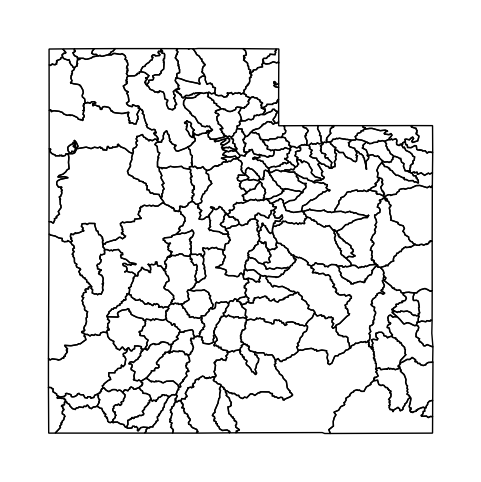

In [34]:
# map the polygons
gdtemp = dfAllShape.copy()
gdtemp = gdtemp[gdtemp['RU_Type'] == 'Subarea'].reset_index(drop=True)
gdtemp = gpd.GeoDataFrame(gdtemp, geometry=gdtemp['geometry'], crs="EPSG:4326") # covert to geodataframe
gplt.polyplot(gdtemp)